In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/TFG/notebooks/')

In [3]:
from functions import *

Dependencies installed successfully.


In [4]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Choose inputs

In [106]:
W = 256
dir_paths = ['/content/gdrive/MyDrive/TFG/data/preprocessed/lst','/content/gdrive/MyDrive/TFG/data/preprocessed/wt_interpolated','/content/gdrive/MyDrive/TFG/data/preprocessed/lst/masked','/content/gdrive/MyDrive/TFG/data/preprocessed/ndvi']
list_rgb = [True,False,True,False]

In [107]:
data, time_slots = load_data(dir_paths,W,list_rgb)

In [129]:
inputs = 'ndvi' #'lst+ndvi' for ndvi inputs

In [130]:
data_inputs = data[dir_paths[0]]
data_targets = data[dir_paths[1]]
masked_inputs = data[dir_paths[2]]
ndvi = data[dir_paths[3]]
print('inputs shape:', data_inputs.shape,masked_inputs.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (34, 256, 256, 3) (34, 256, 256, 3) (34, 256, 256)
targets shape: (34, 256, 256)


In [131]:
if len(data_inputs) > 35:
  num_selected = 34

  # Select 35 random indices from the 108 images
  selected_indices = np.random.choice(data_inputs.shape[0], size=num_selected, replace=False)

  # Extract the selected images using the random indices
  selected_inputs = data_inputs[selected_indices]
  selected_targets = data_targets[selected_indices]


Convert inputs to gray images

In [132]:
masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)

(34, 256, 256)
(34, 256, 256)


Split data

In [133]:
if inputs == 'lst':
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(data_inputs, data_targets)
else:
  ndvi_expanded = np.expand_dims(ndvi, axis=-1)  # Shape: (n_samples, 256, 256, 1)

  # Combine LST (RGB) y NDVI in a 4 channel input data
  combined_input = np.concatenate([data_inputs, ndvi_expanded], axis=-1)  # Shape: (n_samples, 256, 256, 4)
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)


## CNN simpler

In [134]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa de aplanamiento
    model.add(layers.Flatten())

    # Capa densa
    model.add(layers.Dense(64, activation='relu'))

    # Capa de salida con activación lineal (para predicciones de temperatura)
    model.add(layers.Dense(256 * 256, activation='linear'))

    # Reshape de la salida a la forma (256, 256)
    model.add(layers.Reshape((256, 256)))

    return model

# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [135]:
simplified_cnn_model = build_simplified_cnn_model(input_shape)
simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 254, 254, 16)        │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 65536)               │       4,259,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_13 (Reshape)                 │ (None, 256, 256)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,137,648 (46.30 MB)

 Trainable params: 12,137,648 (46.30 MB)

 Non-trainable params: 0 (0.00 B)

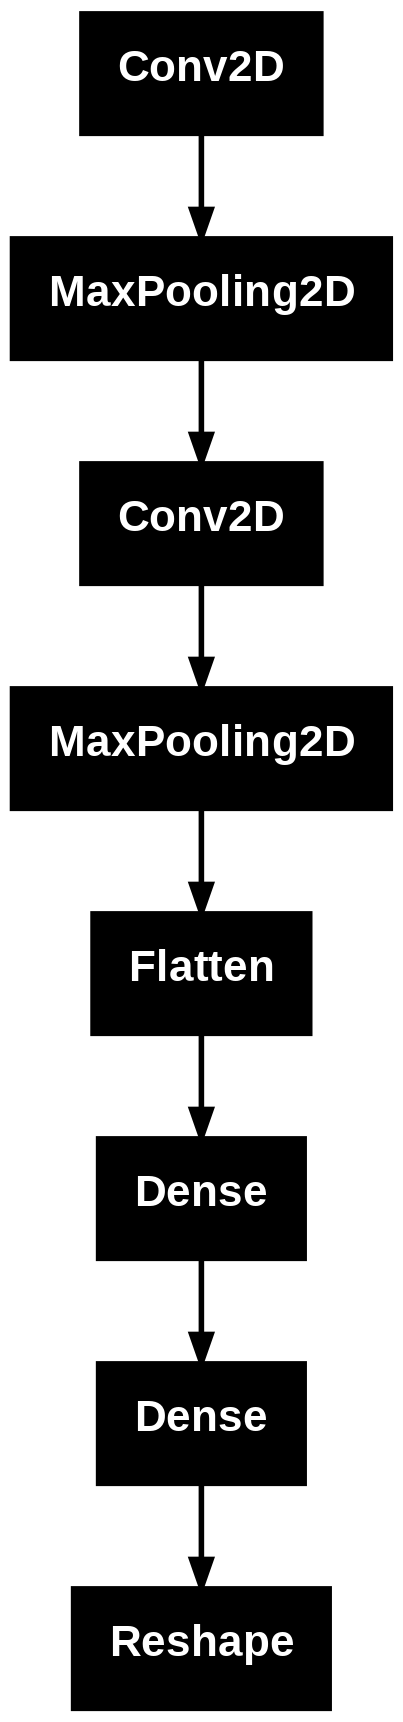

In [152]:
tf.keras.utils.plot_model(simplified_cnn_model)

In [136]:
history = simplified_cnn_model.fit(train_input, train_target, batch_size=4, epochs=10, validation_data=(validation_input, validation_target))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - loss: 1.5756 - mae: 0.2238 - val_loss: 1.0008 - val_mae: 0.2347
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - loss: 0.7217 - mae: 0.2499 - val_loss: 0.6179 - val_mae: 0.2170
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - loss: 0.4713 - mae: 0.2207 - val_loss: 0.6278 - val_mae: 0.2026
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - loss: 0.4448 - mae: 0.1873 - val_loss: 0.6302 - val_mae: 0.2134
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.4338 - mae: 0.1659 - val_loss: 0.4275 - val_mae: 0.1528
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1965 - mae: 0.1055 - val_loss: 0.3892 - val_mae: 0.1455
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - loss: 0.3240 - mae: 0.1177 - val_loss: 0.3214 - val_mae: 0.1338
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - loss: 0.1725 - mae: 0.0940 - val_loss: 0.2962 - val_mae: 0.1064
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.2247 - mae: 

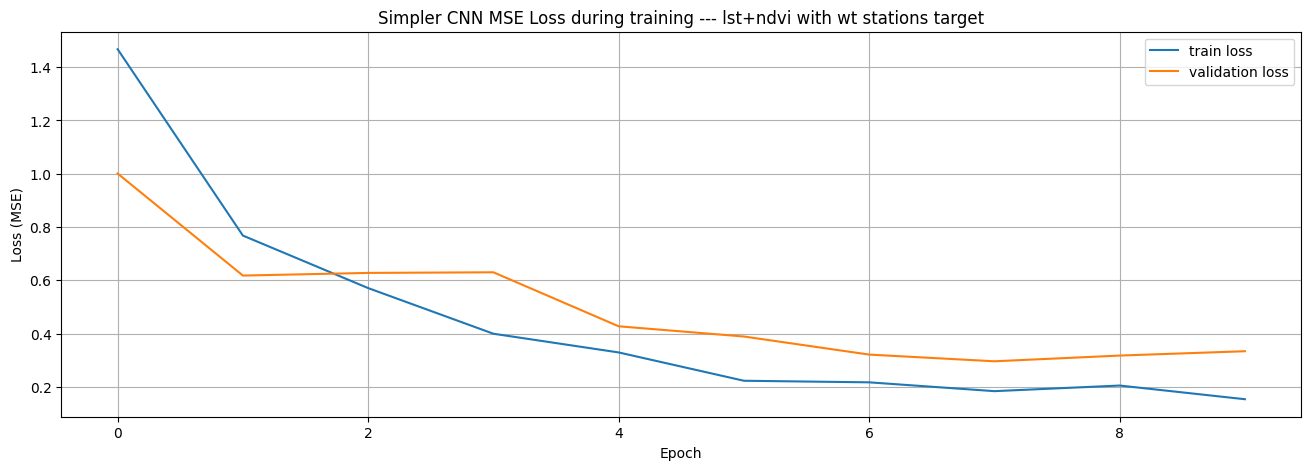

In [150]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt stations target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

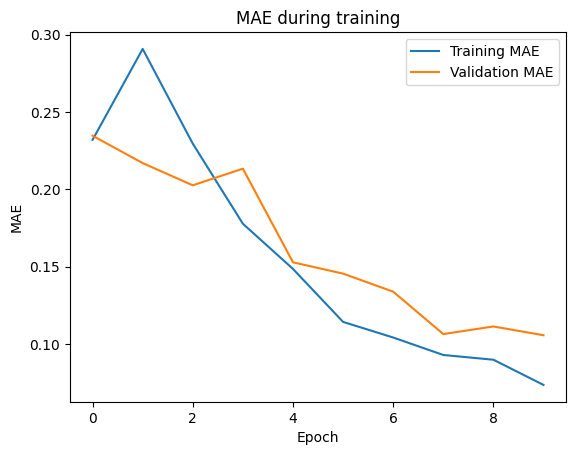

In [138]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [139]:
# Evaluar el modelo en el conjunto de validación
loss, mae = simplified_cnn_model.evaluate(validation_input, validation_target)

print(f'Pérdida (MSE) en validación: {loss}')
print(f'MAE en validación: {mae}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3340 - mae: 0.1057
Pérdida (MSE) en validación: 0.3339932858943939
MAE en validación: 0.10566503554582596


In [140]:
validation_prediction = simplified_cnn_model.predict(validation_input)
test_prediction = simplified_cnn_model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [141]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [142]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

Overall results

In [143]:
results = evaluate_model(val_target_mask, val_pred_mask)
print('Validation results')
for k,v in results.items():
  print(k,':',v)

Validation results
MAE : 1.4569239651818542
MSE : 19.258412443088158
RMSE : 2.322707986215355
R² : 0.6555345435199151
MAPE (%) : 35670.903771850426
MSE sample-wise : 5.394972389228591


In [144]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 0.8272831251577928
MSE : 9.07850353693452
RMSE : 1.2911129076971453
R² : 0.8930695343274456
MAPE (%) : 32125.518916153607
MSE sample-wise : 1.6669725404221774


Image wise metrics results

In [145]:
c = 0
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    samples_per_image = test_target.shape[1]*test_target.shape[2]
    # Flatten the true and predicted values for this sample
    y_true_flatten = test_target_flat[c:c+samples_per_image]
    y_true_mask = y_true_flatten[y_true_flatten!= 0]

    y_pred_flatten = test_prediction_flat[c:c+samples_per_image]
    y_pred_mask = y_pred_flatten[y_true_flatten!= 0]

    #print(y_true_flatten.shape,y_pred_flatten.shape)
    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


    c += samples_per_image

for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 0.8272831251577927, 'MSE': 5.080838504460146, 'RMSE': 1.2316665424824074, 'R²': 0.8849190761200375, 'MAPE (%)': 32125.518916153607, 'MSE sample-wise': 1.666972540422177}


See what are the areas with more prediction error

In [146]:
diff = validation_prediction - validation_target

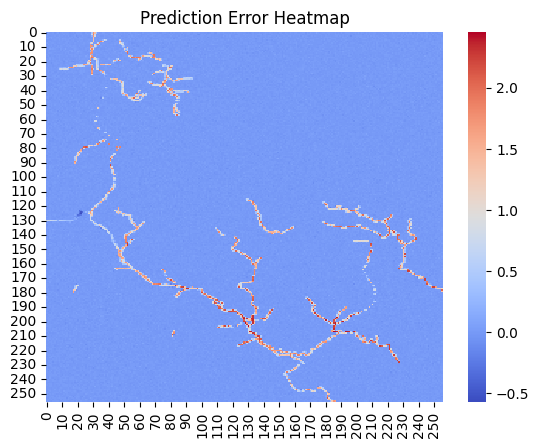

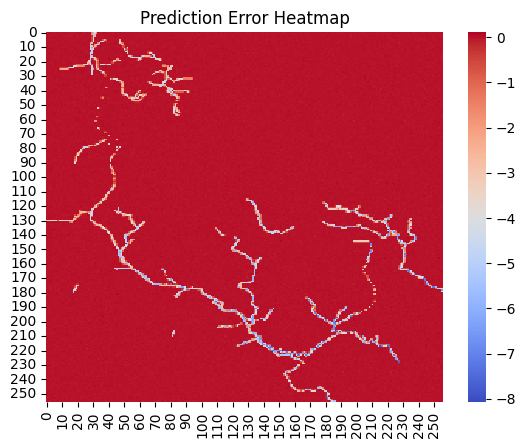

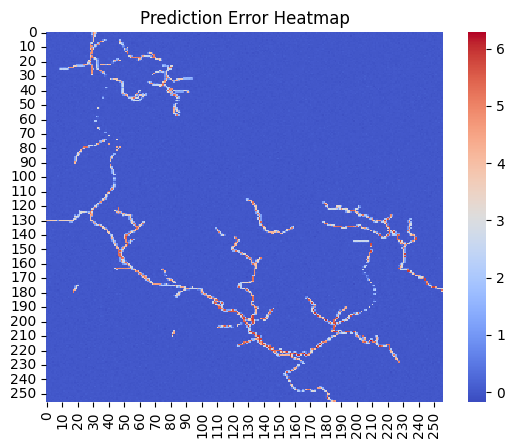

In [147]:
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

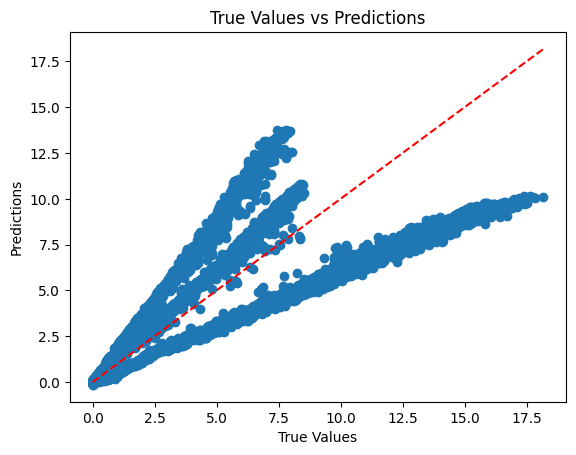

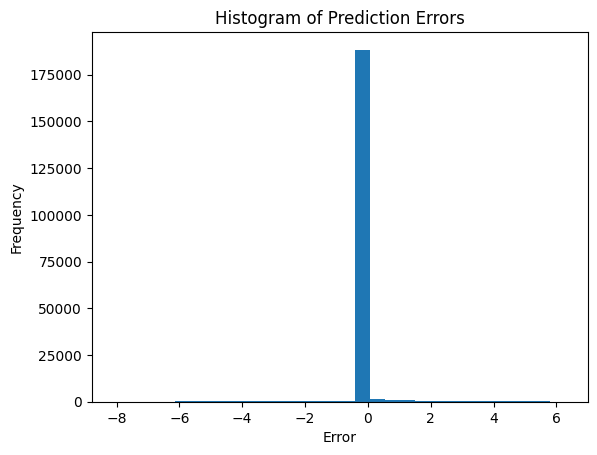

In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [149]:
model_name = "CNN_Simpler_model"
details = "34 lst+ndvi inputs with water stations target, straightforward CNN, 4 epochs"
file_path = "/content/gdrive/MyDrive/TFG/results/model_results.xlsx"


# Update Excel with new results
update_excel_with_results(file_path, model_name, results, details)


file_path = "/content/gdrive/MyDrive/TFG/results/model_results_img_wise.xlsx"
update_excel_with_results(file_path, model_name, mean_results, details)